In [1]:
cd /content/drive/MyDrive/fnd-sample-1/classification_news_model/model-pipeline-news

/content/drive/MyDrive/fnd-sample-1/classification_news_model/model-pipeline-news


In [2]:
ls

label_encoder.pkl  model_creation.ipynb      results/
logs/              news_sinhala_cleaned.csv  wandb/


In [3]:
import pandas as pd

# Upload your CSV to Colab or use files.upload()
df = pd.read_csv("news_sinhala_cleaned.csv")  # or 'large' version
print(df.head(10))

                                                text     label
0  බැංකු වෙතින් මුදල් ගැනීම අත්හිටුවෙනවා කියලා පට...     rumor
1                      රජය නව විදුලිබල නීතියක් පනවයි      news
2  නව ආණ්ඩුව විසින් ඉදිරි වසර තුනක ආර්ථික සැලැස්ම...      news
3  විදේශ ඇමතිවරයා ජර්මනිය සමඟ නව වෙළඳ ගිවිසුමක් අ...      news
4  අද මට බඩ අමාරුවක් තියෙනවා පොඩි පීරීමක්ද මොකක්ද...  non-news
5  පාලමක් කඩා වැටෙනවා කියලා කිව්වට අවසන් විශ්වාසව...     rumor
6  දෙමළ නායකයන් සහ අගමැති අතර සාකච්ඡාවක් අද පැවැත්වේ      news
7  දින දෙකක් තුළම පාසල් වසා දැමෙනවා කියලා ෆේස්බුක...     rumor
8                          අද උදේ තේ කෝප්පයක් වැටුණා  non-news
9  ශ්රී ලංකා ක්රිකට් කණ්ඩායම ඉන්දියාවට එරෙහි තරගය...      news


In [4]:
class_counts = df['label'].value_counts()
print(class_counts)

label
rumor       3334
news        3333
non-news    3333
Name: count, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

In [6]:
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [7]:
print(le.classes_)      # Shows the categories in order of their encoding
print(le.transform(le.classes_))   # Shows how each class is mapped to an integer

['news' 'non-news' 'rumor']
[0 1 2]


In [8]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label_encoded'],
    test_size=0.1, stratify=df['label_encoded'], random_state=42
)

In [9]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=32,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [ ]:
len(le.classes_)

3

In [ ]:
from transformers import XLMRobertaForSequenceClassification

model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=len(le.classes_)
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install wandb

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(p):  # or: def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    f1 = f1_score(p.label_ids, preds, average='macro')
    precision = precision_score(p.label_ids, preds, average='macro')
    recall = recall_score(p.label_ids, preds, average='macro')
    acc = (preds == p.label_ids).mean()
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results",

    # core hyper-parameters
    num_train_epochs=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,

    # when to evaluate / save / log
    eval_strategy="epoch",        # run validation at the end of every epoch
    save_strategy="epoch",        # checkpoint once per epoch
    logging_dir='./logs',
    logging_steps=10,     # log metrics once per epoch

    # keep the best model (by validation accuracy) loaded at the end
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    #report_to="wandb",   # Comment this line if not using wandb
    save_total_limit=2   # Only keep the 2 best models (saves space)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fyp-teaminsight (team-insight) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000500,0.000118,1.000000,1.000000,1.000000,1.000000
2,0.000100,0.000029,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000017,1.000000,1.000000,1.000000,1.000000
4,0.000000,0.000010,1.000000,1.000000,1.000000,1.000000
5,0.000000,0.000007,1.000000,1.000000,1.000000,1.000000
6,0.000000,0.000005,1.000000,1.000000,1.000000,1.000000
7,0.000000,0.000004,1.000000,1.000000,1.000000,1.000000
8,0.000000,0.000003,1.000000,1.000000,1.000000,1.000000
9,0.000000,0.000002,1.000000,1.000000,1.000000,1.000000
10,0.000000,0.000002,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=28150, training_loss=0.002145602961554404, metrics={'train_runtime': 5047.4205, 'train_samples_per_second': 89.154, 'train_steps_per_second': 5.577, 'total_flos': 7400064873600000.0, 'train_loss': 0.002145602961554404, 'epoch': 50.0})

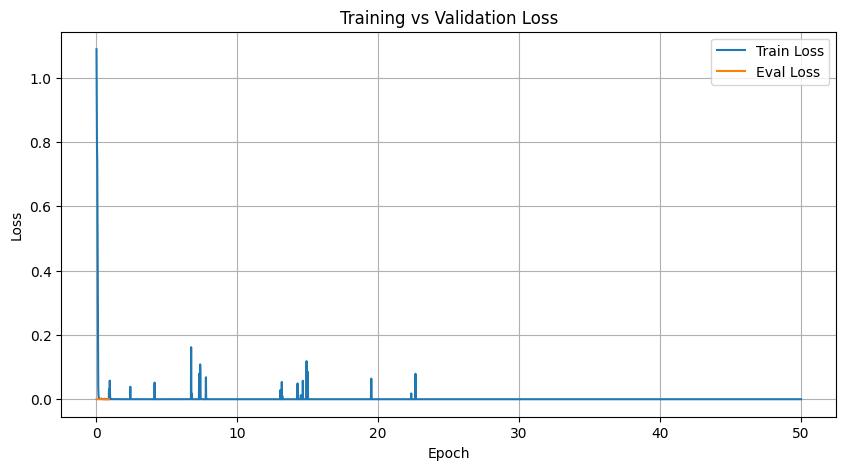

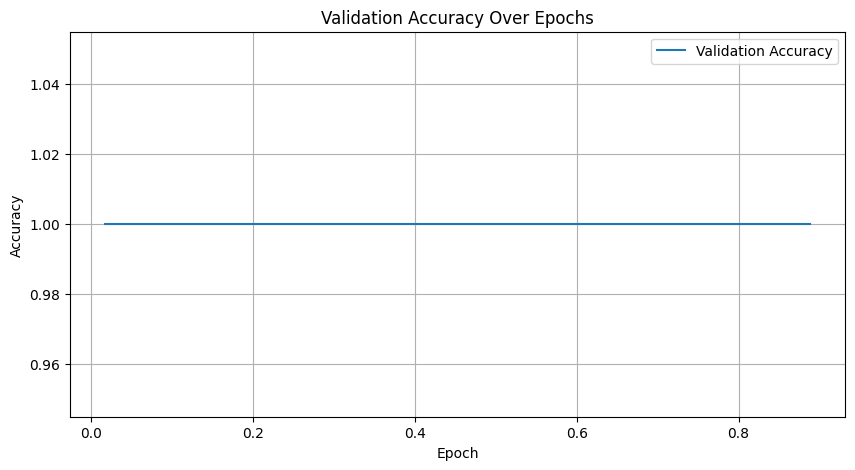

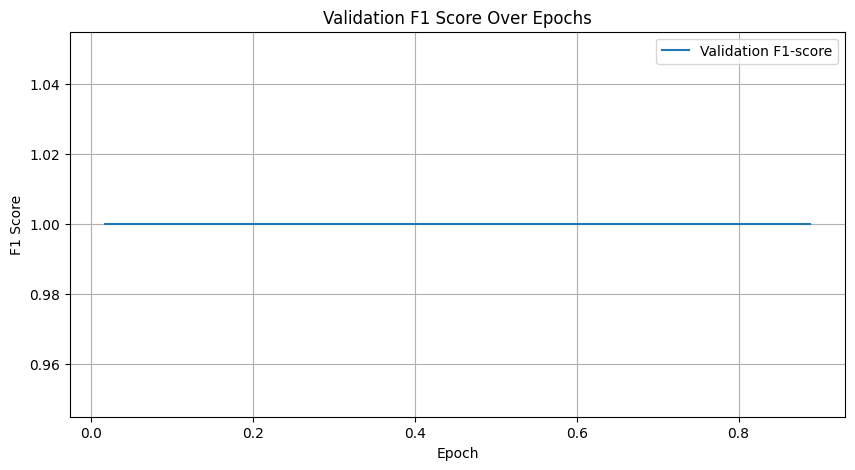

In [ ]:
import matplotlib.pyplot as plt

# Extract log history
log_history = trainer.state.log_history

# Initialize dictionaries to collect metric history
epochs, train_loss, eval_loss = [], [], []
eval_accuracy, eval_f1 = [], []

# Parse logs
for entry in log_history:
    if 'epoch' in entry:
        epoch = entry['epoch']
        if 'loss' in entry:  # training loss
            train_loss.append(entry['loss'])
            epochs.append(epoch)
        if 'eval_loss' in entry:
            eval_loss.append(entry['eval_loss'])
        if 'eval_accuracy' in entry:
            eval_accuracy.append(entry['eval_accuracy'])
        if 'eval_f1' in entry:
            eval_f1.append(entry['eval_f1'])

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label="Train Loss")
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-Score Curve
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(eval_f1)], eval_f1, label="Validation F1-score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

eval_result = trainer.evaluate()
print(eval_result)

# Predict on validation set for full classification report
preds = trainer.predict(val_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
print(classification_report(y_true, y_pred, target_names=le.classes_))

{'eval_loss': 0.00011775076563935727, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.8195, 'eval_samples_per_second': 1220.217, 'eval_steps_per_second': 76.874, 'epoch': 50.0}
              precision    recall  f1-score   support

        news       1.00      1.00      1.00       333
    non-news       1.00      1.00      1.00       333
       rumor       1.00      1.00      1.00       334

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



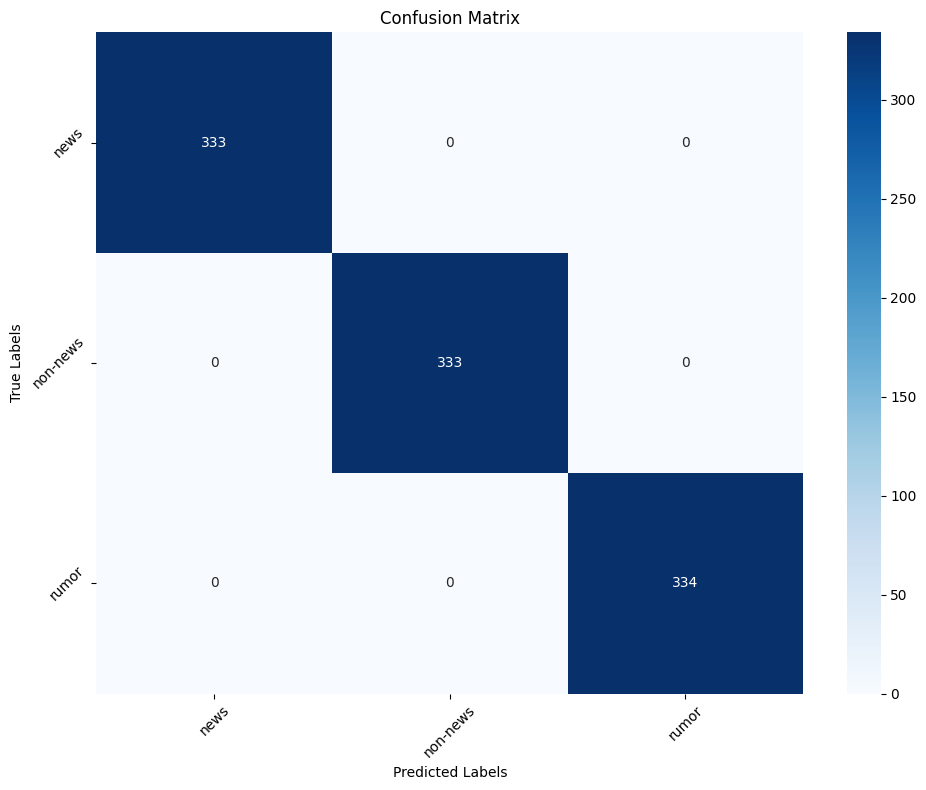

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
trainer.save_model('./fine_tuned_xlm_roberta_news')
tokenizer.save_pretrained('./fine_tuned_xlm_roberta_news')

('./fine_tuned_xlm_roberta_news/tokenizer_config.json',
 './fine_tuned_xlm_roberta_news/special_tokens_map.json',
 './fine_tuned_xlm_roberta_news/sentencepiece.bpe.model',
 './fine_tuned_xlm_roberta_news/added_tokens.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "./fine_tuned_xlm_roberta_news"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
from transformers import TextClassificationPipeline

# Create a pipeline for text classification
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=0)

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
text = "ඊශ්‍රායලයෙන් ඉරානයේ ප්‍රදේශ කිහිපයකට ගුවන් ප්‍රහාර"

result = pipeline(text)
print(result)

[{'label': 'LABEL_0', 'score': 0.9999014139175415}]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Or if you have index:
pred_idx = result[0]['label'].replace("LABEL_", "")  # e.g., "LABEL_2"
label_name = le.inverse_transform([int(pred_idx)])
print(label_name)

['news']


In [ ]:
from transformers import TextClassificationPipeline

def predict_category(model, tokenizer, text, label_encoder=None, sub_to_main=None, device=-1):
    """
    Predicts subcategory and maps it to a main category (if mapping provided).

    Args:
        model: HuggingFace model.
        tokenizer: Tokenizer.
        text (str): Input text.
        label_encoder (LabelEncoder): For decoding subcategory label index.
        sub_to_main (dict): Mapping from subcategory to main category.
        device (int): 0 for GPU, -1 for CPU.

    Returns:
        tuple: (subcategory, main_category or None)
    """
    pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=device)
    result = pipeline(text)[0]

    if label_encoder is not None:
        if result['label'].startswith("LABEL_"):
            sub_idx = int(result['label'].replace("LABEL_", ""))
        else:
            sub_idx = int(result['label'])
        subcategory = label_encoder.inverse_transform([sub_idx])[0]
    else:
        subcategory = result['label']

    main_category = sub_to_main.get(subcategory, None) if sub_to_main else None
    return subcategory, main_category


In [ ]:
subcategory_to_main = {
    "InternationalPolitics": "PoliticsAndGovernance",
    "DomesticPolitics": "PoliticsAndGovernance",
    "TechAndInnovation": "ScienceAndTechnology",
    "ResearchAndSpace": "ScienceAndTechnology",
    "ScreenAndStage": "CultureAndEntertainment",
    "MusicAndArts": "CultureAndEntertainment",
    "Cricket": "Sports",
    "Football": "Sports",
    "Other": "Sports",
    "CrimeReport": "CrimeAndJustice",
    "CourtsAndInvestigation": "CrimeAndJustice"
}

text = "ඊශ්‍රායලයෙන් ඉරානයේ ප්‍රදේශ කිහිපයකට ගුවන් ප්‍රහාර"

subcategory, main_category = predict_category(
    model, tokenizer, text,
    label_encoder=le,
    sub_to_main=subcategory_to_main
)

print(f"Subcategory: {subcategory}")
print(f"Main Category: {main_category}")

Device set to use cuda:0


Subcategory: InternationalPolitics
Main Category: PoliticsAndGovernance


/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
subcategory,main_category

('InternationalPolitics', 'PoliticsAndGovernance')

In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124
